# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [322]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [533]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [534]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [535]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-04-06 21:55:52.371571
metric: deaths at 2020-04-06 21:55:53.621992
Latest data from 2020-04-06


In [536]:
# # TEMP FIX - There are data issues on 2020-03-18; these are corrections that will hopefully be fixed
# state_fixes_20200318 = {'New York': 3083, 
#                         'Washington': 1187, 
#                         'California': 870, 
#                         'Florida': 330, 
#                         'New Jersey': 427, 
#                         'Louisiana': 280}
# for state, val in state_fixes_20200318.items():
#     dfp.loc[(dfp.country == 'US') & 
#             (dfp['date'] == datetime.datetime(2020,3,18)) & 
#             (dfp.state == state), 'confirmed'] = val

In [537]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [538]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-04-06,Italy,132547,3599,16523,636,0.124658
1,2020-04-06,Spain,136675,5029,13341,700,0.097611
2,2020-04-06,US,366614,29542,10783,1164,0.029412
3,2020-04-06,France,98963,5190,8926,833,0.090195
4,2020-04-06,United Kingdom,52279,3843,5385,442,0.103005
5,2020-04-06,Iran,60500,2274,3739,136,0.061802
6,2020-04-06,China,82665,63,3335,2,0.040344
7,2020-04-06,Netherlands,18926,973,1874,103,0.099017
8,2020-04-06,Germany,103374,3251,1810,226,0.017509
9,2020-04-06,Belgium,20814,1123,1632,185,0.078409


<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [539]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
2,2020-04-06,US,366614,29542,10783,1164,0.029412
3,2020-04-06,France,98963,5190,8926,833,0.090195
1,2020-04-06,Spain,136675,5029,13341,700,0.097611
4,2020-04-06,United Kingdom,52279,3843,5385,442,0.103005
0,2020-04-06,Italy,132547,3599,16523,636,0.124658
8,2020-04-06,Germany,103374,3251,1810,226,0.017509
11,2020-04-06,Turkey,30217,3148,649,75,0.021478
5,2020-04-06,Iran,60500,2274,3739,136,0.061802
25,2020-04-06,India,4778,1190,136,37,0.028464
9,2020-04-06,Belgium,20814,1123,1632,185,0.078409


<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [540]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,24))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

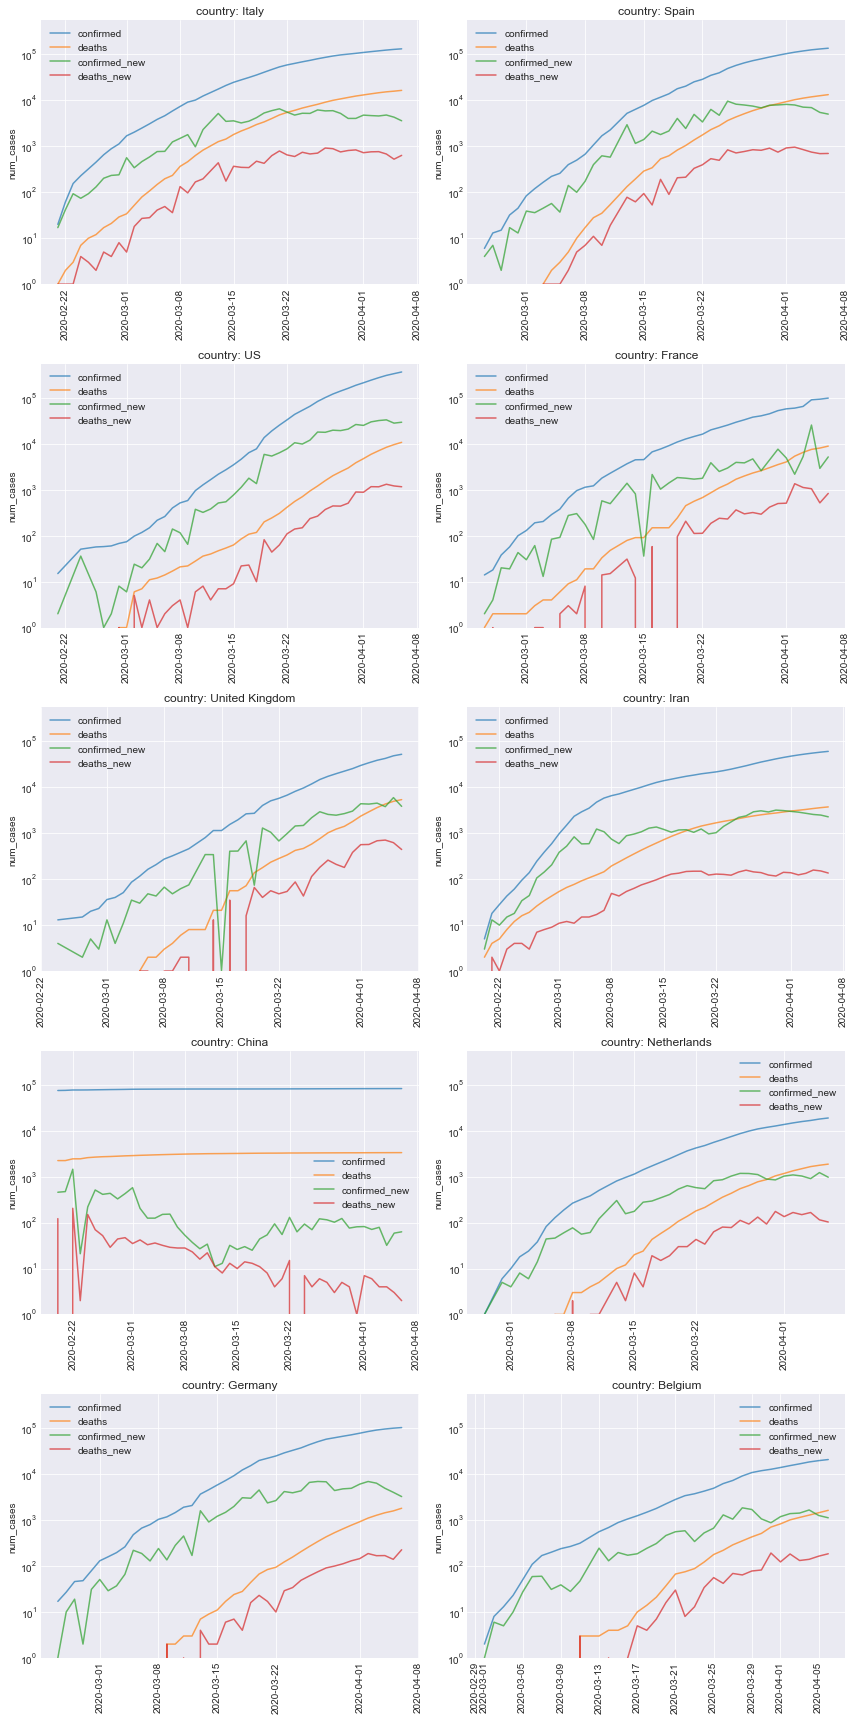

In [541]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

### New deaths

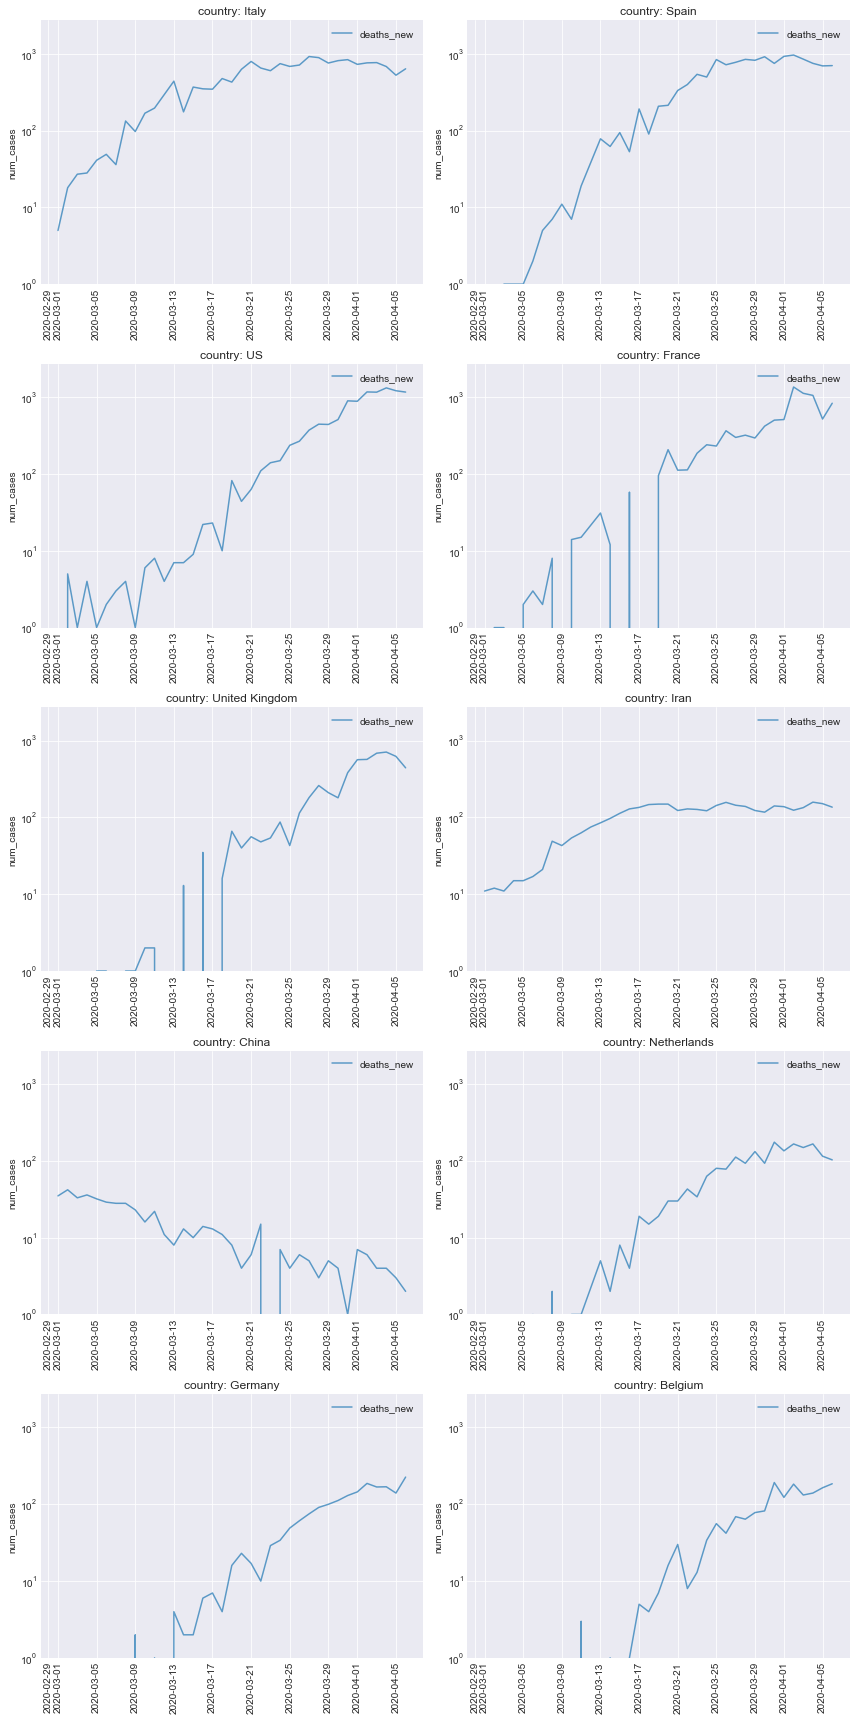

In [542]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,3,1),
               y_max=dfp_country['deaths_new'].max()*2,
               is_log=True
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [543]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-04-07 2020-04-13 2020-04-27  2020-04-07 2020-04-13   
country                                                                      
Italy                138857.0   174347.0   296526.0     17534.0    23320.0   
Spain                148289.0   211181.0   481866.0     14752.0    23156.0   
US                   422600.0   830589.0  4019011.0     13563.0    38181.0   
France               114881.0   231446.0  1186447.0     11395.0    29940.0   
United Kingdom        60755.0   124301.0   660516.0      7092.0    21476.0   
Iran                  64442.0    87307.0   177325.0      3914.0     5056.0   
China                 82735.0    83112.0    83999.0      3341.0     3367.0   
Netherlands           20449.0    30523.0    77714.0      2161.0     3936.0   
Germany              113340.0   163881.0   387436.0      2139.0     4931.0   
Belgium               23167.0    38208.0   122788.0      1925.0     4416.0   

                          mortality_rate_pred                        \
date           2020-04-27          2020-04-07 2020-04-13 2020-04-27   
country                                                               
Italy             45362.0            0.126274   0.133756   0.152978   
Spain             66305.0            0.099481   0.109650   0.137600   
US               427198.0            0.032094   0.045969   0.106294   
France           285211.0            0.099190   0.129361   0.240391   
United Kingdom   284841.0            0.116731   0.172774   0.431240   
Iran               9191.0            0.060737   0.057911   0.051831   
China              3428.0            0.040382   0.040512   0.040810   
Netherlands       15948.0            0.105678   0.128952   0.205214   
Germany           34612.0            0.018872   0.030089   0.089336   
Belgium           30620.0            0.083092   0.115578   0.249373   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
Italy                         0.038663             0.048674  
Spain                         0.060696             0.078038  
US                            0.119205             0.188263  
France                        0.123828             0.174686  
United Kingdom                0.126717             0.202787  
Iran                          0.051913             0.043611  
China                         0.000759             0.001291  
Netherlands                   0.069033             0.105096  
Germany                       0.063386             0.149333  
Belgium                       0.086962             0.148337

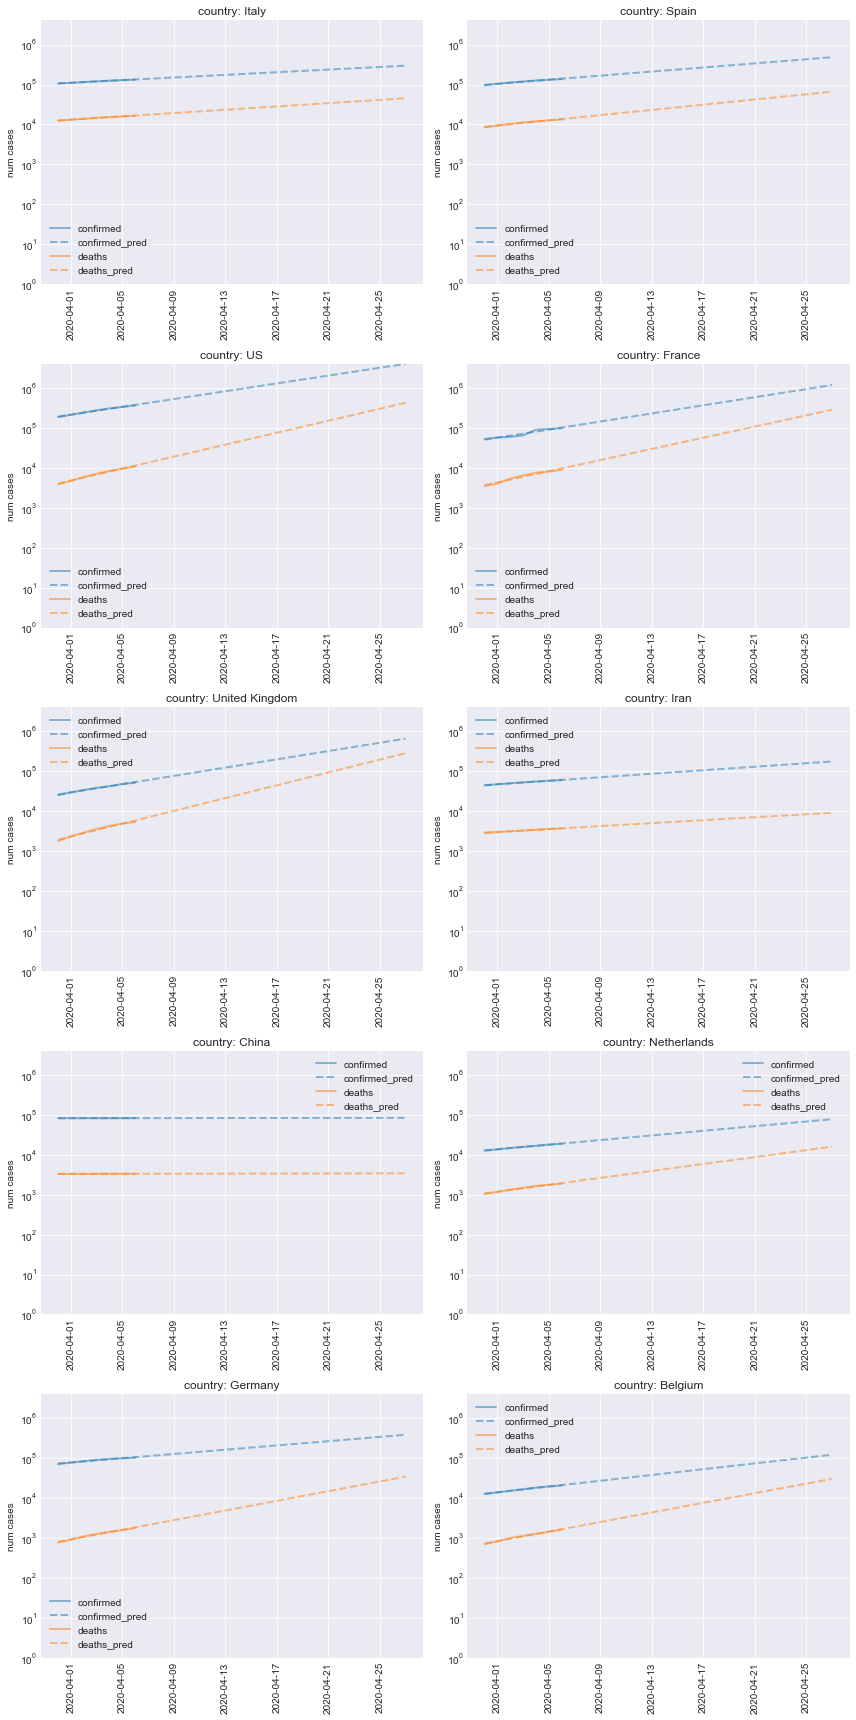

In [544]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [545]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-04-06_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [546]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


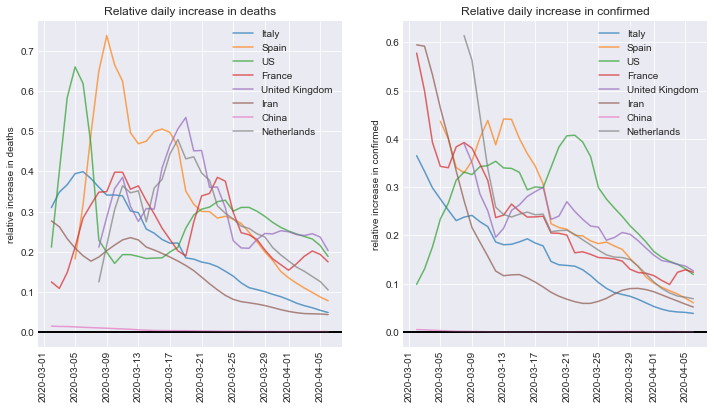

In [547]:
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=datetime.datetime(2020,3,2))

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-04-07 2020-04-13  2020-04-07 2020-04-13   
country                                                           
Italy                145543.0   195100.0     19054.0    28684.0   
Spain                168553.0   289288.0     17385.0    34625.0   
US                   485020.0  1166130.0     15803.0    56455.0   
France               113854.0   225208.0     11525.0    30769.0   
United Kingdom        66994.0   157723.0      7771.0    27371.0   
Iran                  69496.0   105658.0      4026.0     5413.0   
China                 82824.0    83336.0      3341.0     3367.0   
Netherlands           22701.0    39207.0      2600.0     6263.0   
Germany              126137.0   212368.0      2593.0     7971.0   
Belgium               27215.0    56083.0      2407.0     7868.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-04-07 2020-04-13                           
country                                                                 
Italy                     0.130917   0.147022                0.050052   
Spain                     0.103143   0.119690                0.094205   
US                        0.032582   0.048412                0.157439   
France                    0.101226   0.136625                0.120398   
United Kingdom            0.115995   0.173538                0.153389   
Iran                      0.057931   0.051231                0.072318   
China                     0.040339   0.040403                0.001028   
Netherlands               0.114532   0.159742                0.095350   
Germany                   0.020557   0.037534                0.090706   
Belgium                   0.088444   0.140292                0.128071   

               frac_increase_deaths  
date                                 
country                              
Italy                      0.070551  
Spain                      0.121679  
US                         0.236397  
France                     0.177818  
United Kingdom             0.233470  
Iran                       0.050540  
China                      0.001291  
Netherlands                0.157780  
Germany                    0.205768  
Belgium                    0.218182

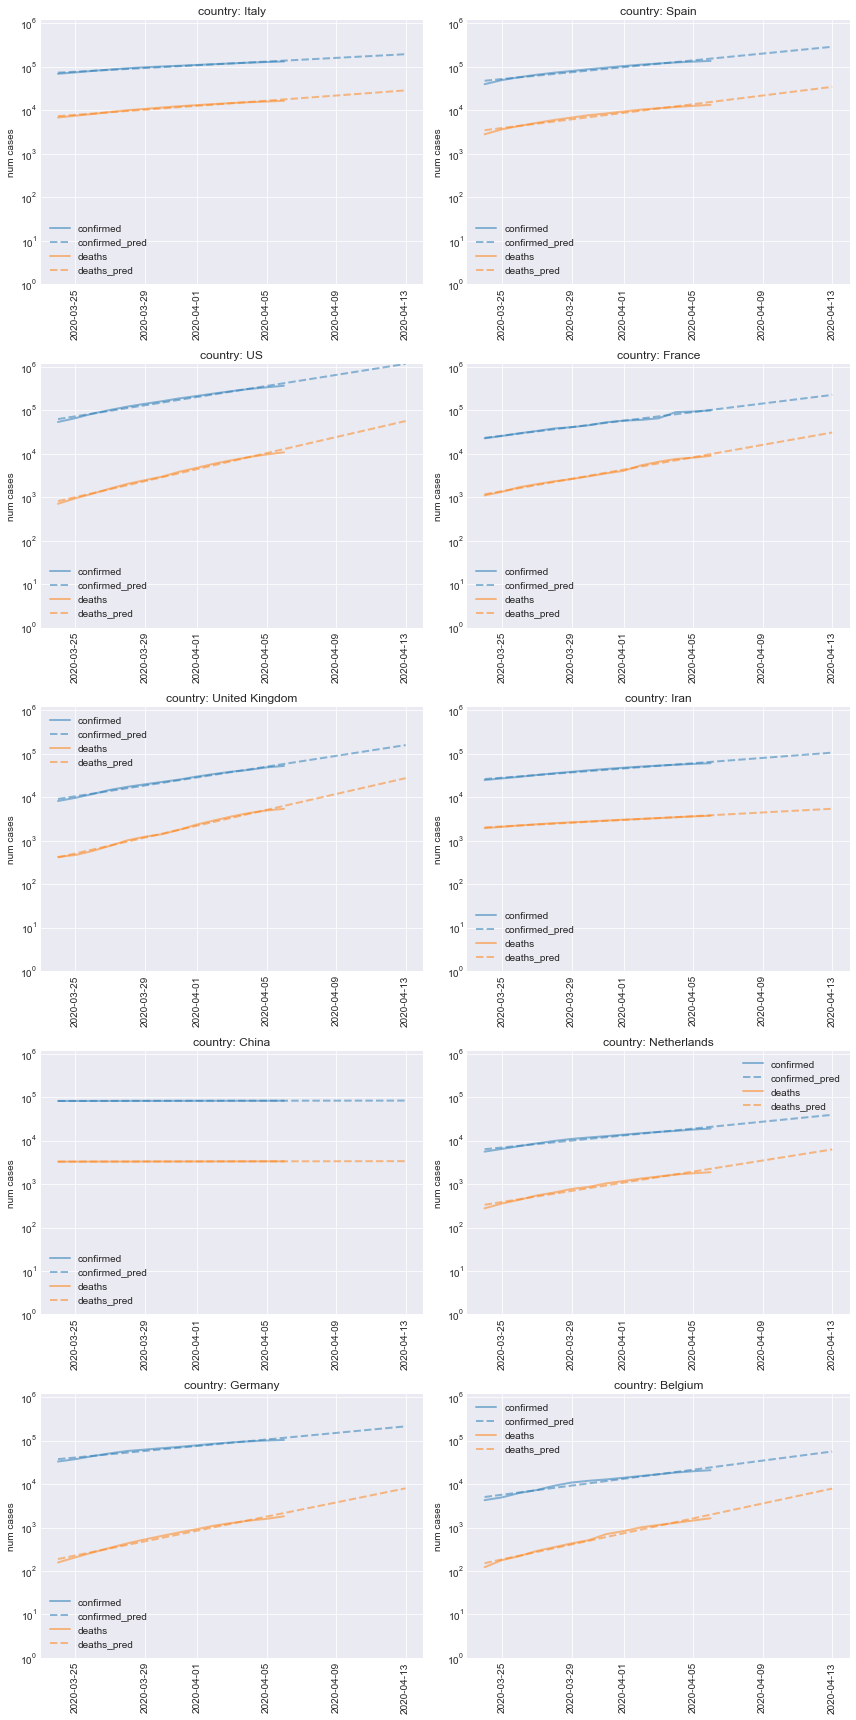

In [548]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [549]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-04-06_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [550]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

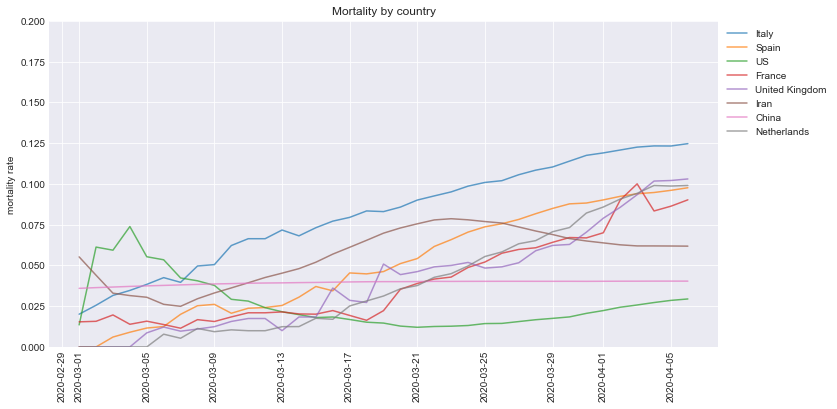

In [551]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [552]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'Mortality vs confirmed cases by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

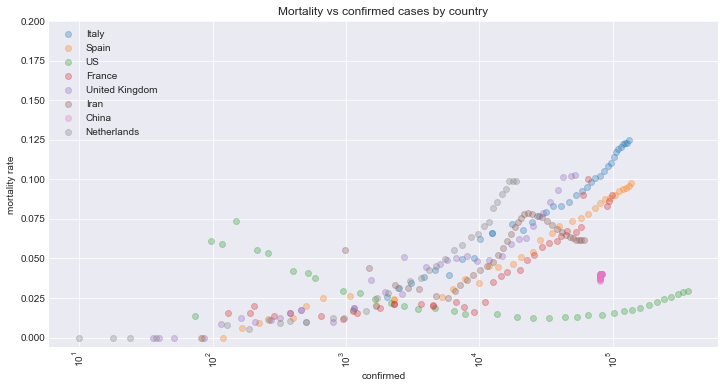

In [553]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [554]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

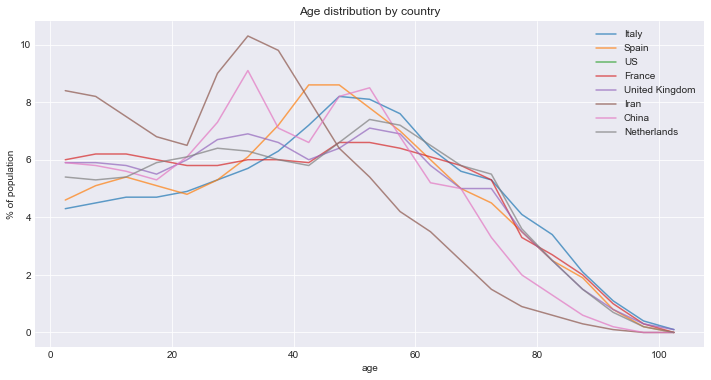

In [555]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

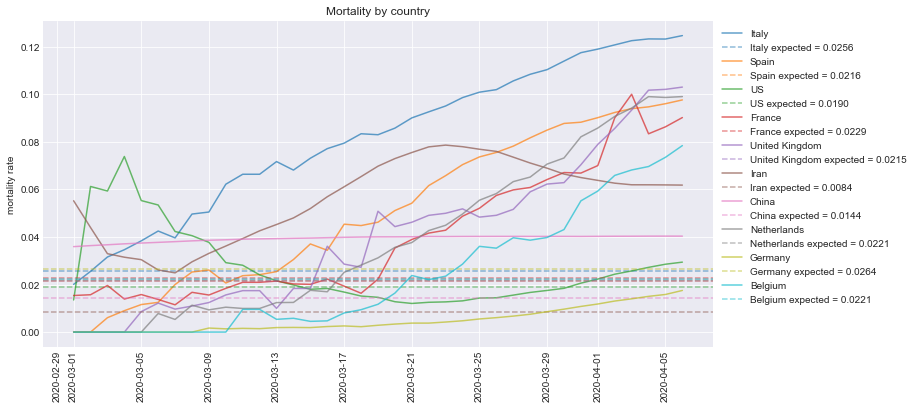

,date,country,mortality_rate,confirmed,deaths
0,2020-04-06,Italy,0.124658,132547.0,16523.0
1,2020-04-06,United Kingdom,0.103005,52279.0,5385.0
2,2020-04-06,Netherlands,0.099017,18926.0,1874.0
3,2020-04-06,Spain,0.097611,136675.0,13341.0
4,2020-04-06,France,0.090195,98963.0,8926.0
5,2020-04-06,Belgium,0.078409,20814.0,1632.0
6,2020-04-06,Iran,0.061802,60500.0,3739.0
7,2020-04-06,China,0.040344,82665.0,3335.0
8,2020-04-06,US,0.029412,366614.0,10783.0
9,2020-04-06,Germany,0.017509,103374.0,1810.0


In [556]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

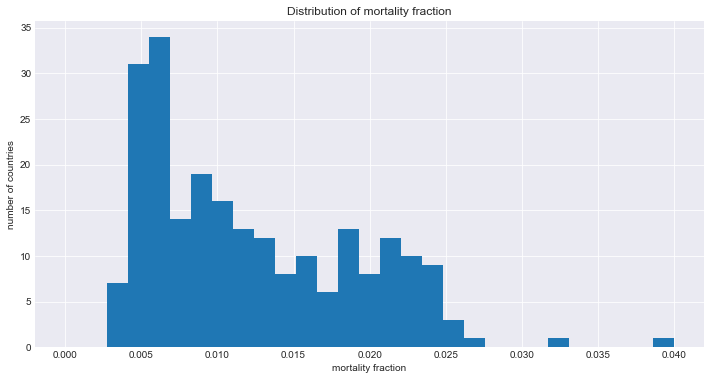

In [557]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [558]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

,country,frac_mortality,num_deaths_max_expected,pop
1,Japan,0.031837,3998380.024,125507472
2,Germany,0.026398,2128411.026,80159662
3,Greece,0.025745,271233.247,10607051
4,Italy,0.025637,1599267.592,62402659
10,Portugal,0.023736,244829.259,10302674
18,France,0.022950,1564984.503,67848156
20,Sweden,0.022575,231555.716,10202491
23,Belgium,0.022146,259573.363,11720716
24,Netherlands,0.022076,382222.125,17280397
27,Canada,0.021712,820035.480,37694085


<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [559]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

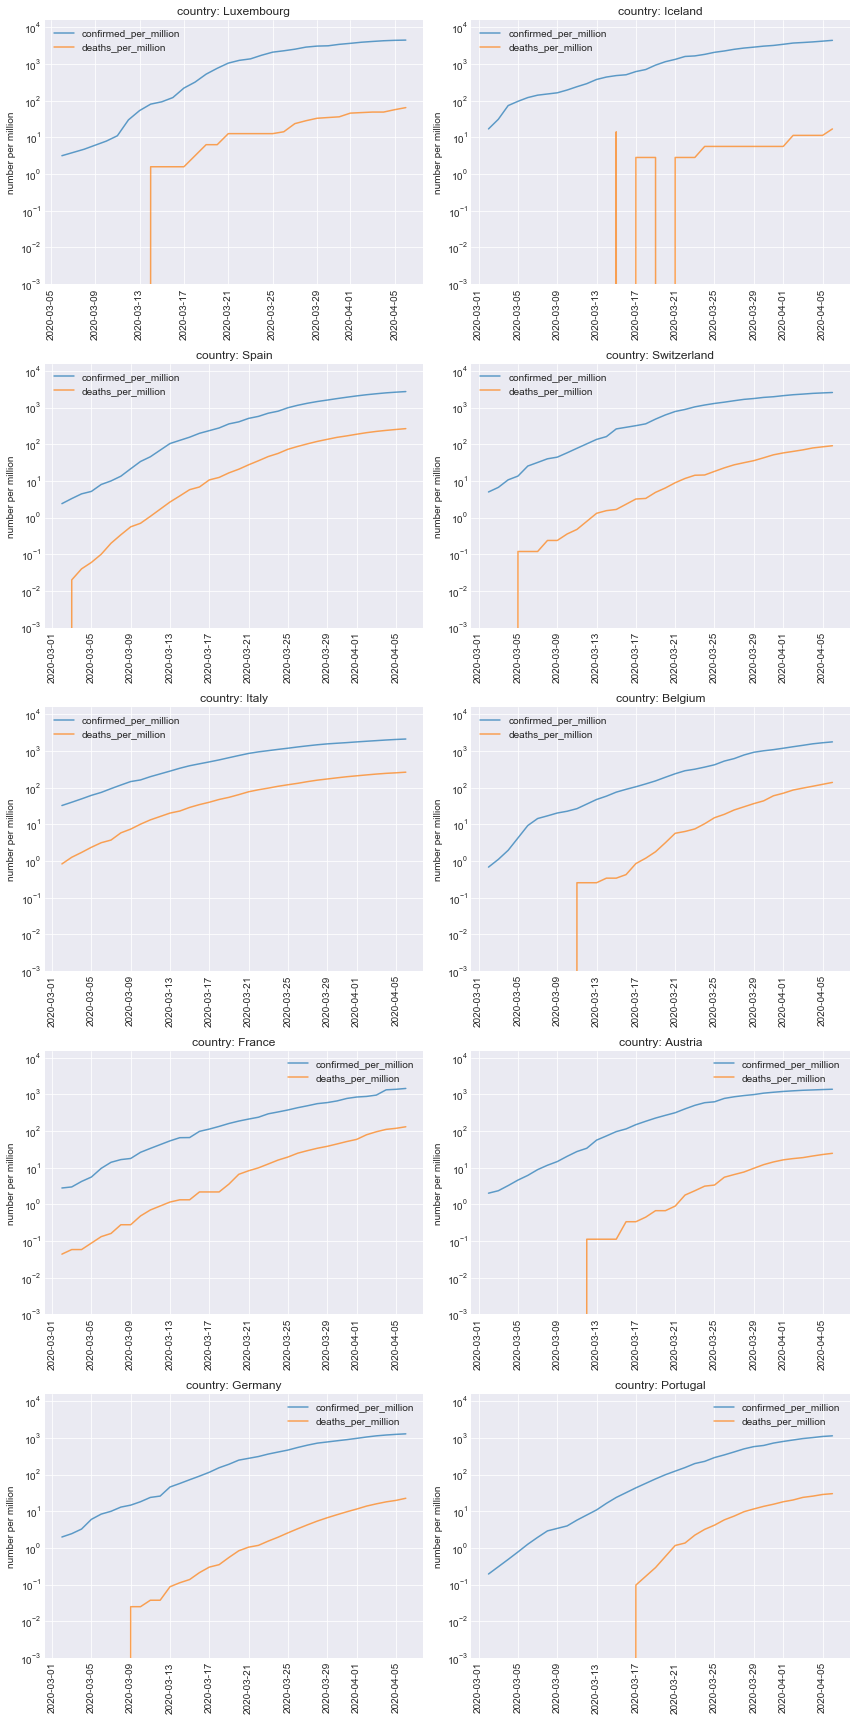

,country,population,confirmed,deaths,confirmed_per_million,deaths_per_million,mortality_rate
0,Luxembourg,628381.0,2843.0,41.0,4524.325210,65.247040,0.014421
1,Iceland,350734.0,1562.0,6.0,4453.517480,17.106981,0.003841
2,Spain,50015792.0,136675.0,13341.0,2732.636924,266.735754,0.097611
3,Switzerland,8403994.0,21657.0,765.0,2576.988989,91.028147,0.035323
4,Italy,62402659.0,132547.0,16523.0,2124.060130,264.780384,0.124658
5,Belgium,11720716.0,20814.0,1632.0,1775.830077,139.240640,0.078409
6,France,67848156.0,98963.0,8926.0,1458.595279,131.558476,0.090195
7,Austria,8859449.0,12297.0,220.0,1388.009570,24.832244,0.017891
8,Germany,80159662.0,103374.0,1810.0,1289.601246,22.579936,0.017509
9,Portugal,10302674.0,11730.0,311.0,1138.539373,30.186338,0.026513


In [560]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

### Mortality rate by deaths per capita, confirmed per capita

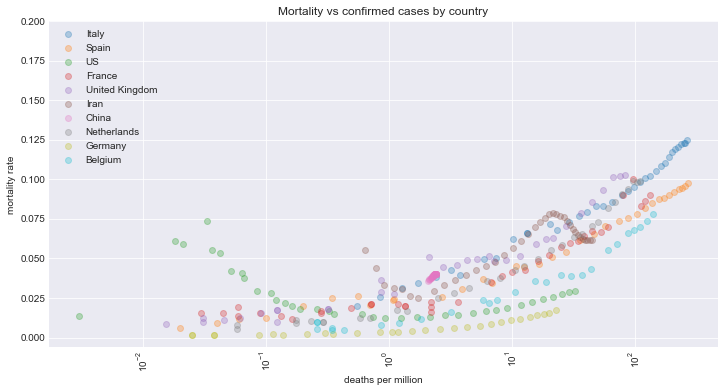

In [561]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

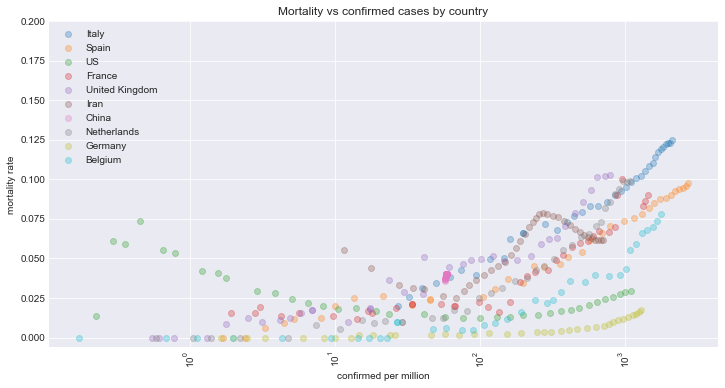

In [562]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [563]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

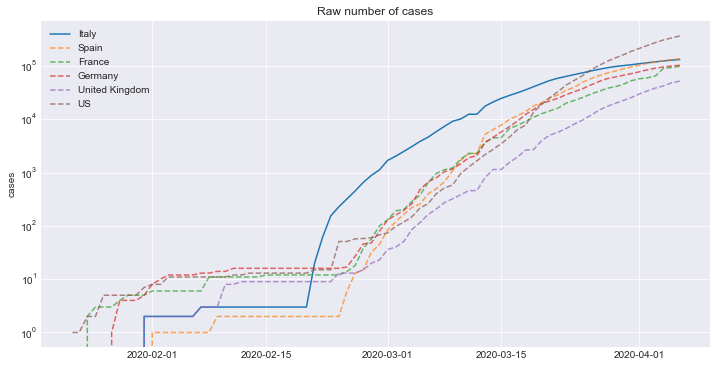

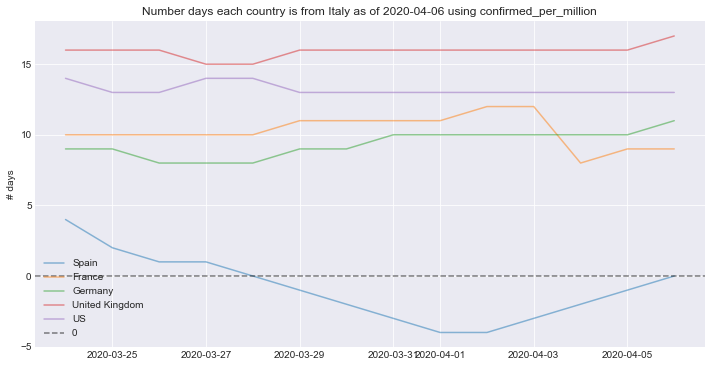

In [564]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

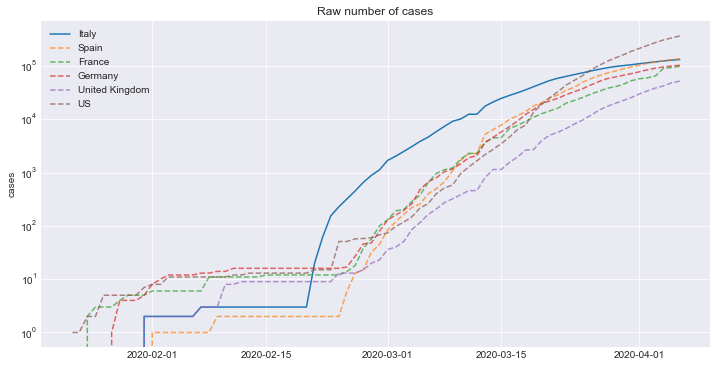

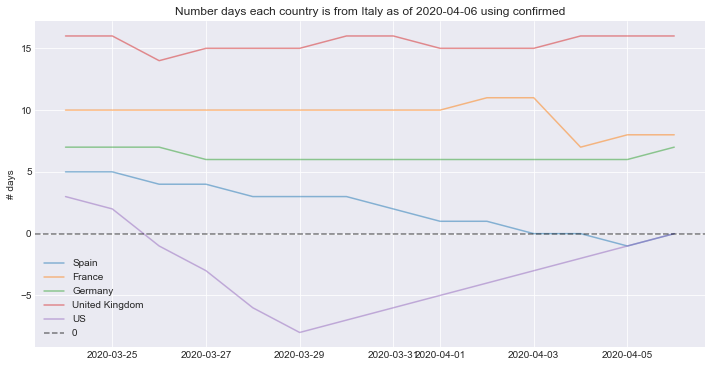

In [565]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [566]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [567]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [568]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [569]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [570]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(10)

,date,state,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-04-06,New York,131815,8655,4698,539,0.035641
1,2020-04-06,New Jersey,41090,3585,1003,86,0.024410
2,2020-04-06,Michigan,17221,1503,727,110,0.042216
3,2020-04-06,Louisiana,14867,1857,512,35,0.034439
4,2020-04-06,Washington,8311,486,381,45,0.045843
5,2020-04-06,California,16019,985,380,32,0.023722
6,2020-04-06,Illinois,12262,1003,307,33,0.025037
7,2020-04-06,Massachusetts,13837,1337,260,29,0.018790
8,2020-04-06,Florida,13324,974,236,15,0.017712
9,2020-04-06,Georgia,7314,667,229,18,0.031310


<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [571]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

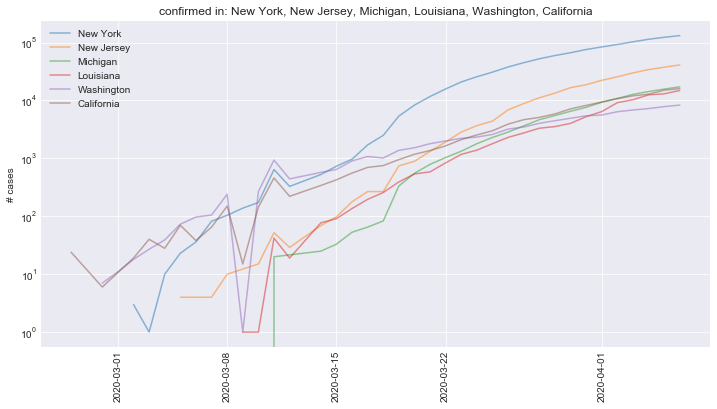

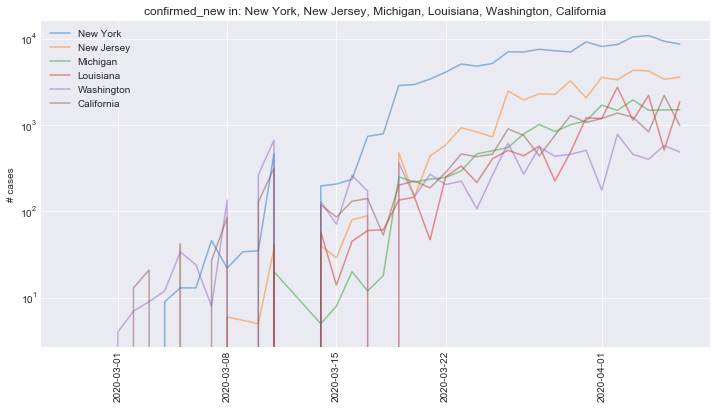

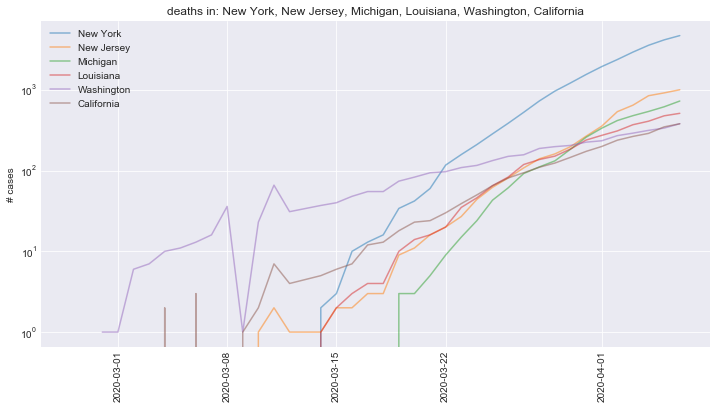

In [572]:
states_oi = dfp_us_top_states.iloc[:6]['state'].values
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed')
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new')
plot_state_data(dfp_us_g, states_oi, plot_col='deaths')

<a id='forecast_us_state'></a>
### Forecast by state

confirmed_pred                       deaths_pred             \
date              2020-04-07 2020-04-13 2020-04-27  2020-04-07 2020-04-13   
state                                                                       
New York            148050.0   260261.0   970683.0      6001.0    18515.0   
New Jersey           48945.0   108016.0   684897.0      1461.0     5666.0   
Michigan             20703.0    46446.0   306018.0       879.0     2345.0   
Louisiana            19256.0    54467.0   616280.0       604.0     1330.0   
California           18342.0    35794.0   170338.0       441.0      969.0   
Washington            9048.0    14094.0    39639.0       410.0      693.0   
Illinois             14310.0    29655.0   162381.0       400.0     1201.0   
Massachusetts        16275.0    34015.0   189975.0       339.0      956.0   
Florida              15901.0    33235.0   185631.0       320.0      955.0   
Georgia               8248.0    14790.0    57781.0       272.0      543.0   

                         mortality_rate_pred                        \
date          2020-04-27          2020-04-07 2020-04-13 2020-04-27   
state                                                                
New York        256601.0            0.040534   0.071140   0.264351   
New Jersey      133759.0            0.029850   0.052455   0.195298   
Michigan         23118.0            0.042458   0.050489   0.075545   
Louisiana         8371.0            0.031367   0.024418   0.013583   
California        6083.0            0.024043   0.027072   0.035711   
Washington        2366.0            0.045314   0.049170   0.059689   
Illinois         15601.0            0.027952   0.040499   0.096077   
Massachusetts    10710.0            0.020829   0.028105   0.056376   
Florida          12238.0            0.020125   0.028735   0.065926   
Georgia           2713.0            0.032978   0.036714   0.046953   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.098584             0.206566  
New Jersey                   0.141026             0.253352  
Michigan                     0.144156             0.177552  
Louisiana                    0.189215             0.140408  
California                   0.117873             0.140155  
Washington                   0.076656             0.091603  
Illinois                     0.129132             0.200958  
Massachusetts                0.130729             0.188325  
Florida                      0.130736             0.199836  
Georgia                      0.102228             0.121749

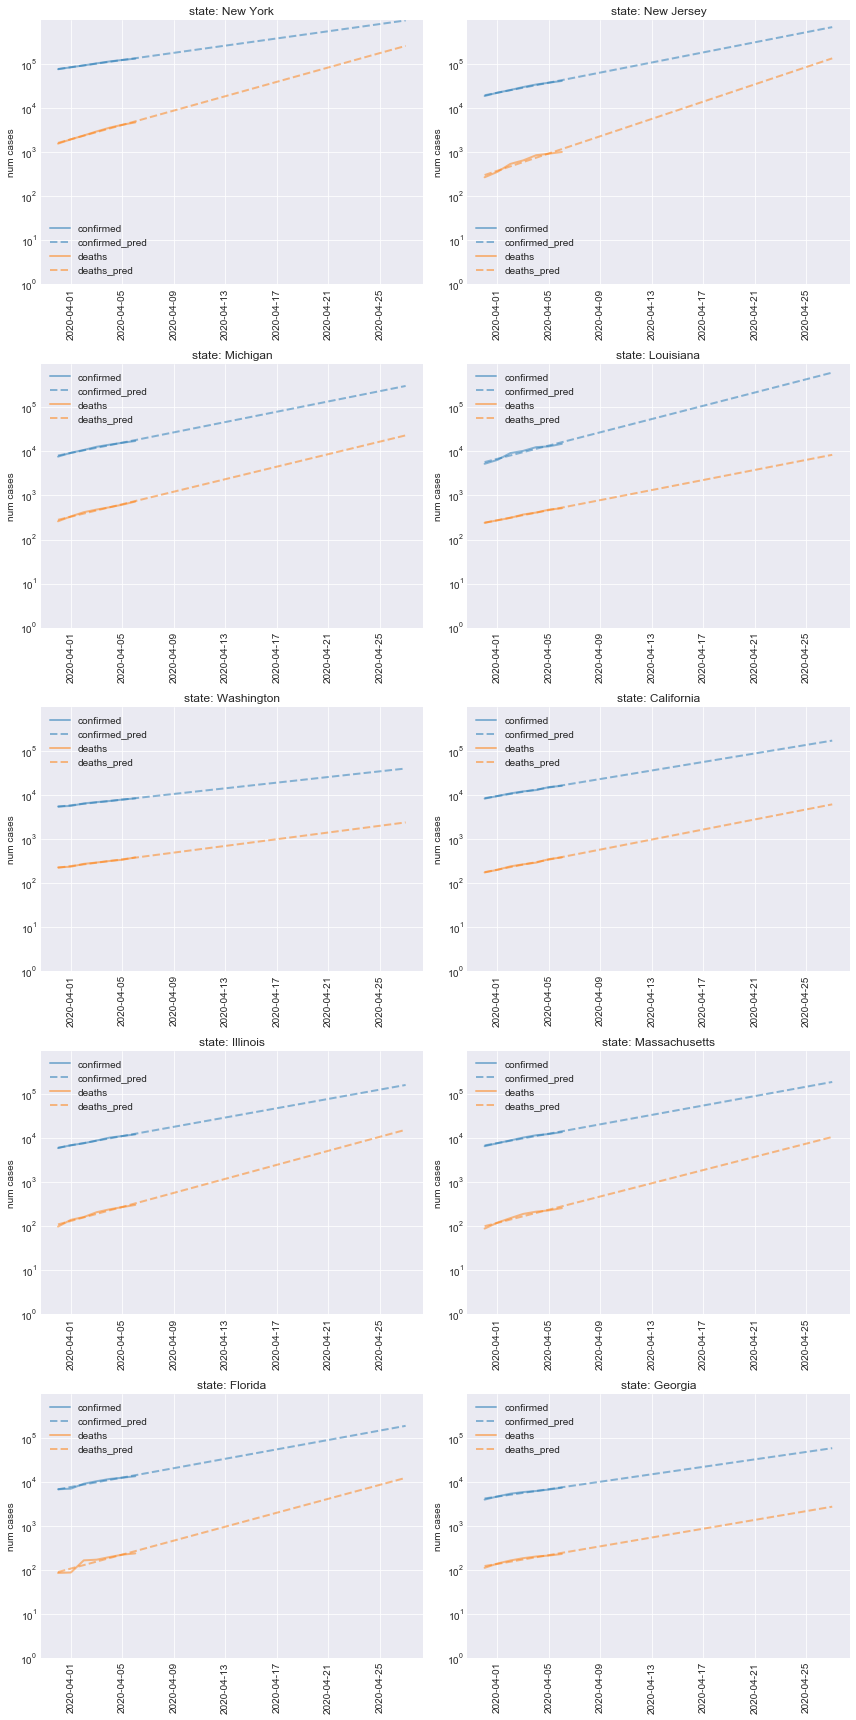

In [573]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [574]:
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state', 'confirmed', 'deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in ['confirmed', 'deaths']:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [575]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state', 'confirmed', 'deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in ['confirmed', 'deaths']:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
(dfp_state_increase_m[['date', 'state', 'confirmed', 'deaths', 'frac_increase_confirmed', 'frac_increase_deaths']].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


,date,state,confirmed,deaths,frac_increase_confirmed,frac_increase_deaths
0,2020-04-06,Hawaii,387,5,1.229010e-01,0.364376
1,2020-04-06,Maryland,4045,91,1.603486e-01,0.275266
2,2020-04-06,North Carolina,2962,45,1.177875e-01,0.258787
3,2020-04-06,West Virginia,345,4,1.368539e-01,0.254835
4,2020-04-06,New Hampshire,715,9,1.401064e-01,0.254129
5,2020-04-06,New Jersey,41090,1003,1.410260e-01,0.253352
6,2020-04-06,Kentucky,955,45,8.397883e-02,0.252939
7,2020-04-06,Rhode Island,1082,27,1.359465e-01,0.231480
8,2020-04-06,Wisconsin,2449,78,9.732374e-02,0.229339
9,2020-04-06,Missouri,2736,47,1.159604e-01,0.222249


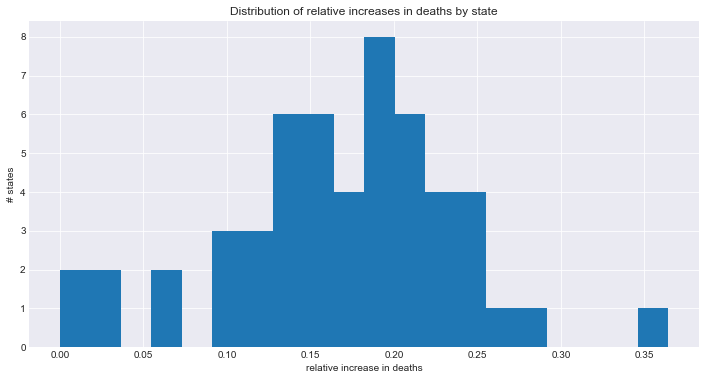

In [576]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

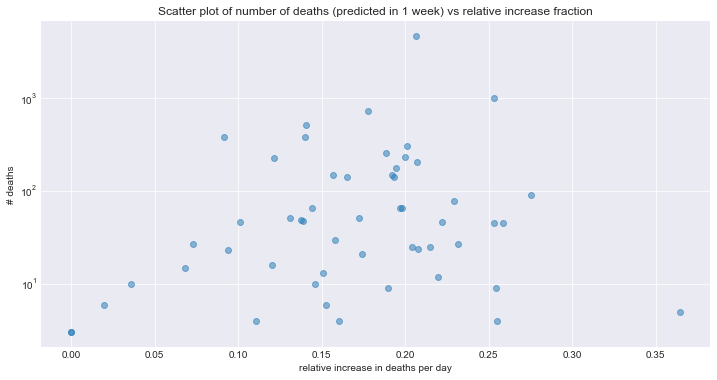

In [577]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [578]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

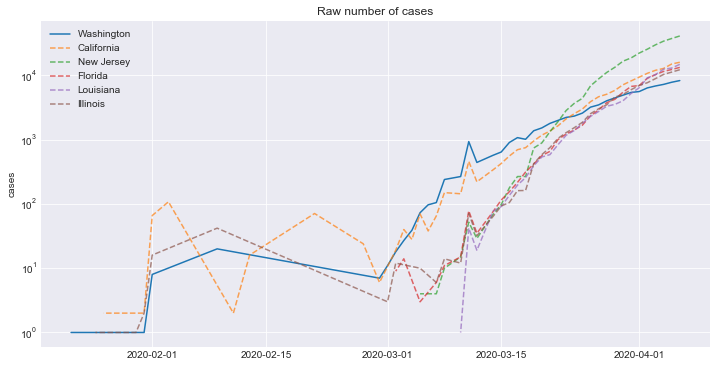

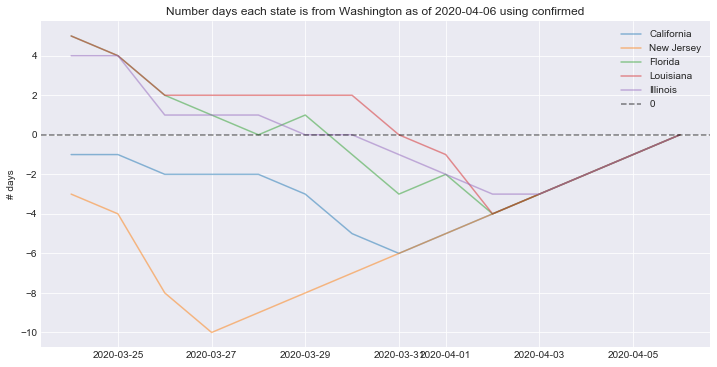

In [579]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

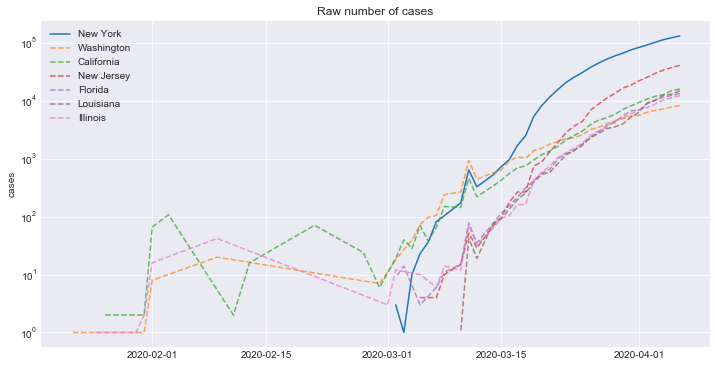

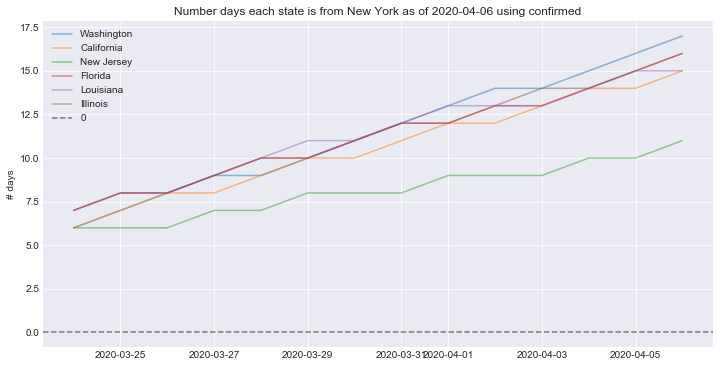

In [580]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

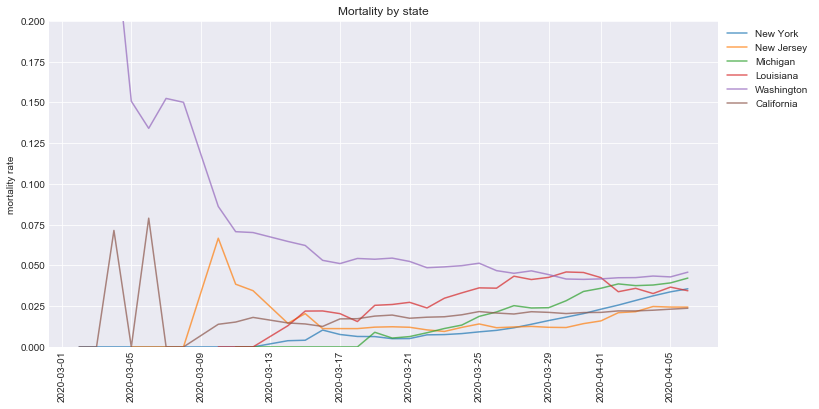

In [581]:
n_states = 6
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

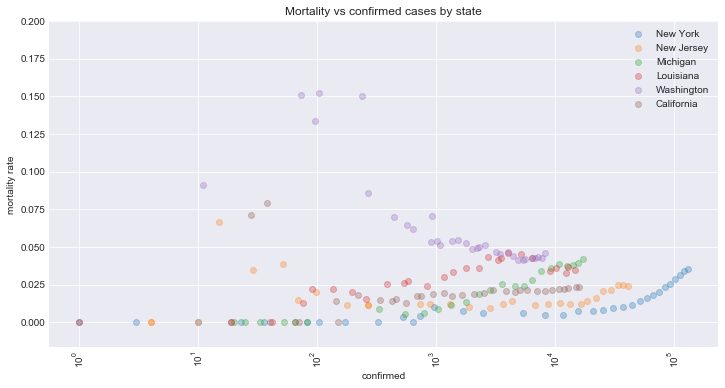

In [582]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

In [ ]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state')
